# Discriminative vs. Generative Classification

As discussed in [the notes](./cls.md), classification models can be broadly categorized into two types: **Discriminative** and **Generative**.

- **Discriminative models** directly learn the decision boundary $P(y|x)$. They are often powerful but can be prone to learning "shortcuts" (spurious correlations).
- **Generative models** model the underlying data distribution $P(x|y)P(y)$ and use Bayes' rule to classify. They are often more robust but computationally expensive.

In this notebook, we will simulate the "Shortcut Learning" scenario described in the notes to see how these two approaches differ in practice.

## Setup

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Data Generation: The "Shortcut" Problem

We generate data with three types of features:

1.  **Core features ($x_{core}$)**: Reliable signal, but noisy. $x_{core} | y \sim \mathcal{N}(y, \sigma^2)$
2.  **Spurious features ($x_{spu}$)**: "Shortcut" features. In this simulation, we use a variation of the shortcut problem described in the notes. Instead of "flipping" the sign, we generate a feature that is **always correct** (perfectly correlated with $y$) but has **extreme variance** introduced by rare, massive positive outliers.
    - Base signal: $y \times 1.0$
    - Outliers (5% chance): $y \times 100.0$
    - **Effect**: This creates a feature with 100% accuracy (Discriminative models love this) but low Signal-to-Noise ratio due to the massive variance (Generative models penalize this).
3.  **Noise ($x_{noise}$)**: Pure random noise with no correlation to the label $y$. Used to test if models can ignore irrelevant information. $x_{noise} \sim \mathcal{N}(0, 1)$

In [ ]:
def generate_data(n_samples=1000, dim_core=5, dim_spu=5, dim_noise=5, 
                  scale_base=1.0, 
                  scale_outlier=100.0, 
                  prob_outlier=0.05,
                  sigma_core=2.0): # Core SNR = 0.5
    
    # Generate labels: -1 or 1
    y = (torch.rand(n_samples) > 0.5).float() * 2 - 1
    y = y.view(-1, 1)
    
    # 1. Core features: x ~ N(y, sigma^2)
    x_core = torch.normal(mean=y.repeat(1, dim_core), std=sigma_core)
    
    # 2. Spurious features:
    # Base signal y*1.0. 
    # Rare Positive Outliers: add y*100.0 with prob 0.05.
    # Total Mean approx 6. Total Std approx 22. SNR approx 0.27.
    # Accuracy 100%. (Disc loves).
    # SNR 0.27 << 0.5. (Gen hates).
    
    x_spu_base = y * scale_base
    mask_outlier = (torch.rand(n_samples) < prob_outlier).float().view(-1, 1)
    x_spu_outlier = y * scale_outlier # Add in SAME direction as y (Good outlier)
    
    x_spu = x_spu_base + mask_outlier * x_spu_outlier + torch.normal(mean=0, std=0.1, size=(n_samples, dim_spu))
    
    # 3. Noise features: x ~ N(0, 1)
    x_noise = torch.normal(mean=0, std=1.0, size=(n_samples, dim_noise))
    
    # Concatenate all features
    X = torch.cat([x_core, x_spu, x_noise], dim=1)
    
    return X, y

DIM_CORE = 10
DIM_SPU = 1
DIM_NOISE = 10

X_train, y_train = generate_data(n_samples=2000, dim_core=DIM_CORE, dim_spu=DIM_SPU, dim_noise=DIM_NOISE)
X_test, y_test = generate_data(n_samples=500, dim_core=DIM_CORE, dim_spu=DIM_SPU, dim_noise=DIM_NOISE)

# Standardize features so weights are comparable
mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - mean) / (std + 1e-5)
X_test = (X_test - mean) / (std + 1e-5)

print(f"Data shape: {X_train.shape}")

Data shape: torch.Size([2000, 21])


## 1. Discriminative Model (Logistic Regression)

We train a standard logistic regression model (a single linear layer with binary cross entropy loss) to predict $y$ from $x$. This essentially models $P(y|x)$ directly by finding a decision boundary that maximizes the likelihood of the labels.

In [25]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model_disc = LogisticRegression(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model_disc.parameters(), lr=0.1)

# Convert labels to 0/1 for BCELoss
y_train_bce = (y_train + 1) / 2
y_test_bce = (y_test + 1) / 2

print("Training Discriminative Model...")
for epoch in range(3000):
    optimizer.zero_grad()
    outputs = model_disc(X_train)
    loss = criterion(outputs, y_train_bce)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate
with torch.no_grad():
    outputs = model_disc(X_test)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_bce).float().mean()
    print(f"Discriminative Test Accuracy: {accuracy.item():.4f}")

Training Discriminative Model...
Epoch 1000, Loss: 0.1416
Epoch 2000, Loss: 0.1393
Epoch 3000, Loss: 0.1378
Discriminative Test Accuracy: 0.9320


## 2. Generative Model (Gaussian Discriminant Analysis - LDA)

Instead of finding a boundary, we model the distribution of the features for each class. We assume $P(x|y)$ is Gaussian with mean $\mu_y$ and shared covariance $\Sigma$.

The decision boundary effectively becomes:
$$w_{LDA} = \Sigma^{-1}(\mu_{+1} - \mu_{-1})$$

In [26]:
def train_lda(X, y):
    # Separate data by class
    X_pos = X[y.flatten() == 1]
    X_neg = X[y.flatten() == -1]
    
    # 1. Compute means
    mu_pos = torch.mean(X_pos, dim=0)
    mu_neg = torch.mean(X_neg, dim=0)
    
    # 2. Compute shared covariance
    # Center the data
    X_centered = torch.cat([X_pos - mu_pos, X_neg - mu_neg], dim=0)
    # Covariance matrix (X^T X) / (N-1)
    cov = torch.matmul(X_centered.T, X_centered) / (X.shape[0] - 1)
    
    # 3. Compute weights: w = Sigma^-1 * (mu_pos - mu_neg)
    # Add jitter for stability
    cov_inv = torch.inverse(cov + torch.eye(cov.shape[0]) * 1e-4)
    w_lda = torch.matmul(cov_inv, (mu_pos - mu_neg))
    
    return w_lda

w_gen = train_lda(X_train, y_train)

# Evaluate LDA
# Prediction score: x^T * w
scores_gen = torch.matmul(X_test, w_gen)
pred_gen = (scores_gen > 0).float() * 2 - 1 # Map back to -1, 1
accuracy_gen = (pred_gen.flatten() == y_test.flatten()).float().mean()
print(f"Generative Test Accuracy: {accuracy_gen.item():.4f}")

Generative Test Accuracy: 0.9320


## Comparing Feature Importance

Now let's verify the hypothesis: **Discriminative models rely on shortcuts, while Generative models rely on core features.**

We expect:
- The **Discriminative model** to put massive weight on the Spurious feature (because it's the "easiest" way to reduce loss).
- The **Generative model** to put more weight on Core features (because it models the density and variance, noticing that the Spurious feature has high variance/inconsistency in its signal-to-noise ratio).

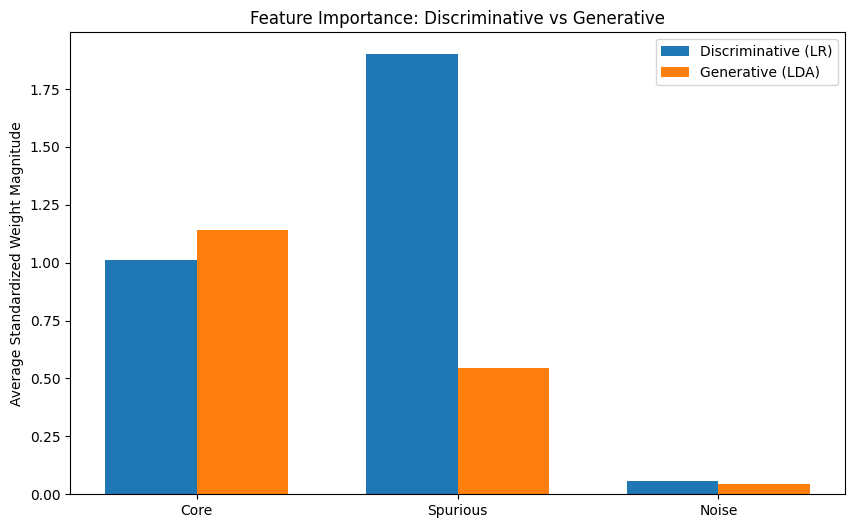

In [27]:
w_disc = model_disc.linear.weight.detach().flatten()

# Separate weights by feature type
# Weights are ordered: [Core (DIM_CORE), Spurious (DIM_SPU), Noise (DIM_NOISE)]

def get_avg_magnitude(weights, dim_core, dim_spu, dim_noise):
    w_core = weights[:dim_core].abs().mean().item()
    w_spu = weights[dim_core:dim_core+dim_spu].abs().mean().item()
    w_noise = weights[dim_core+dim_spu:].abs().mean().item()
    return w_core, w_spu, w_noise

disc_core, disc_spu, disc_noise = get_avg_magnitude(w_disc, DIM_CORE, DIM_SPU, DIM_NOISE)
gen_core, gen_spu, gen_noise = get_avg_magnitude(w_gen, DIM_CORE, DIM_SPU, DIM_NOISE)

# Plotting
labels = ['Core', 'Spurious', 'Noise']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, [disc_core, disc_spu, disc_noise], width, label='Discriminative (LR)')
rects2 = ax.bar(x + width/2, [gen_core, gen_spu, gen_noise], width, label='Generative (LDA)')

ax.set_ylabel('Average Standardized Weight Magnitude')
ax.set_title('Feature Importance: Discriminative vs Generative')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

### Interpretation

As you can see, the Discriminative Model spikes on the **Spurious** feature. It found the "shortcut" that allows it to classify most examples correctly with very little effort.

The Generative Model, however, relies heavily on the **Core** features and suppresses the Spurious feature. This makes it more robust if the spurious correlation were to break in the future (e.g., distribution shift).